**1. Import Dependencies and Data**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install tensorflow tensorflow-datasets ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.5 MB/s eta 0:00:00


In [3]:
#pip list

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
# Importing Tensorflow.The below code is to prevent the GPU devices in eating up all RAM
"""gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)"""

"gpus = tf.config.experimental.list_physical_devices('GPU')\nfor gpu in gpus:\n    tf.config.experimental.set_memory_growth(gpu, True)"

In [5]:
# Importing Tensorflow datasets for fashion mnist
# Use tensorflow dataset API to download the dataset and use only training set

dataset_name = "fashion_mnist"  # Replace with the dataset you want
ds = tfds.load(name=dataset_name, split="train")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteH4UL1O/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteH4UL1O/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [6]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

# **2. Visualise data and Build dataset**

In [7]:
import numpy as np
dataiterator = ds.as_numpy_iterator()


In [8]:
dataiterator.next()['image'].shape

(28, 28, 1)

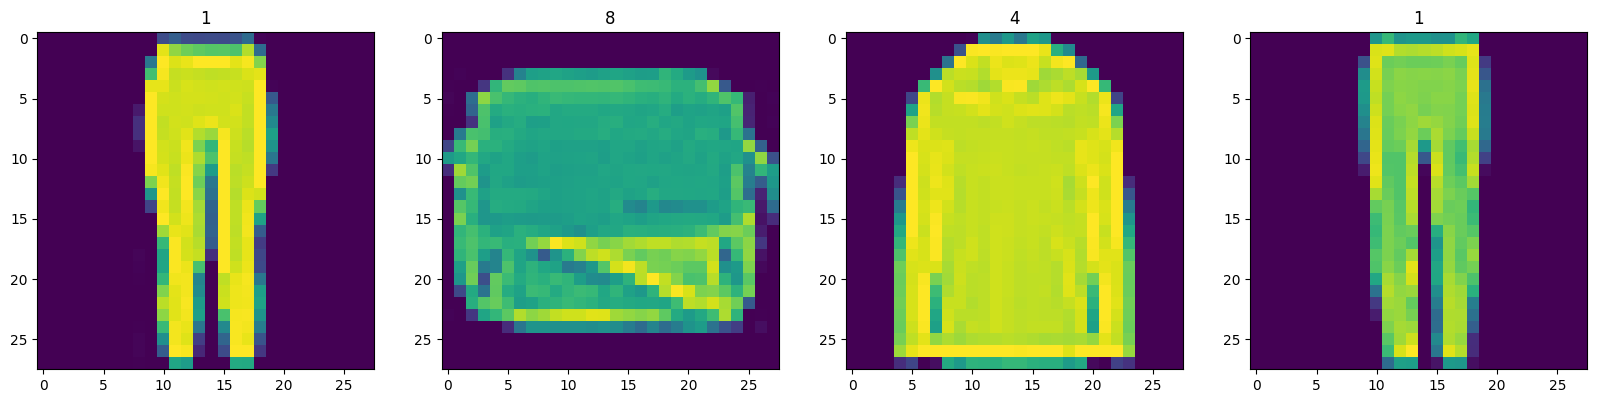

In [9]:
# setup subplot format
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#loop four times and get images
for idx in range(4):
  #grab an image and label it
  sample = dataiterator.next()
  #plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(sample['image']))
  # Appending the image label as the plot title . Its optional
  ax[idx].title.set_text(sample['label'])

In [10]:
# Function to scale image between 0 and 1 & return images
def scale_images(data):
  image = data['image']
  return image / 255

In [11]:
# Reloaded the dataset
ds = tfds.load('fashion_mnist', split = 'train')
# Running the dataset through scale_images preprocessing step
ds = ds.map(scale_images)
# cache the dataset for the batch
ds = ds.cache()
# shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

**3. Build Neural Networks**

In [13]:
# Importing Modelling Components
# Bringing the sequential API for Generator and Discriminator
from tensorflow.keras.models import Sequential
# Bringing the layers for neural netwroks
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

**3.1 Build Generator**

In [14]:
def build_generator():
  model = Sequential()
  # Takes random values and reshape it to 7x7x128
  # Begining of a generated image
  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling Block1
  model.add(UpSampling2D())
  # 5 is the kernel filter 5*5 , 128 is the no of channels
  model.add(Conv2D(128, 5 , padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling Block2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5 , padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional Block1
  model.add(Conv2D(128, 4 , padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional Block2
  model.add(Conv2D(128, 4 , padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional layer to get 1 channel
  # reducing the channel to 1 to meet the input dim . Using sigmoid to get output between 0 and 1
  model.add(Conv2D(1, 4 , padding='same', activation='sigmoid'))

  return model


In [15]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 2s 2s/step


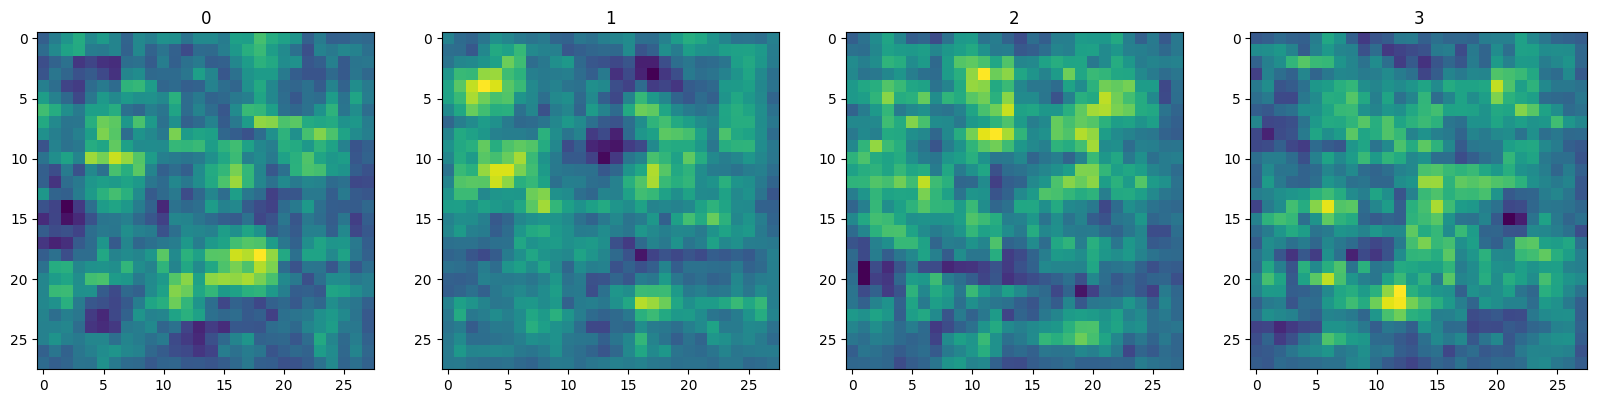

In [16]:
# generate new fashion
img = generator.predict(np.random.randn(4, 128, 1))
# setup subplot format
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#loop four times and get images
for idx, img in enumerate(img):
  #plot the image using a specific subplot
  ax[idx].imshow(np.squeeze(img))
  # Appending the image label as the plot title . Its optional
  ax[idx].title.set_text(idx)

**3.2 Build Discriminator**

In [17]:
def build_discriminator():
  model = Sequential()
  # First conv block
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  # Dropout is for regularization
  model.add(Dropout(0.4))

  # Second conv block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third conv block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Fourth conv block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model


In [18]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

**4.Construct Training Loop**

**4.1 Setup Losses and Optimisers**

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [20]:
# Need to keep the learning rate of discriminator slower than generator learning rate
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

**4.2 Build Subclasses Model**

In [21]:
from tensorflow.keras.models import Model


In [22]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}


In [23]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [24]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

**4.3 Build the Callback**

In [25]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [26]:
class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

**4.3 Train**

In [28]:
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=100, callbacks=[ModelMonitor()])

Epoch 1/100
  6/469 [..............................] - ETA: 1:13 - d_loss: 0.6722 - g_loss: 0.6865

469/469 [==============================] - 76s 162ms/step - d_loss: 0.6922 - g_loss: 0.6843
Epoch 2/100
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6957 - g_loss: 0.6515
Epoch 3/100
469/469 [==============================] - 77s 164ms/step - d_loss: 0.6808 - g_loss: 0.6862
Epoch 4/100
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6647 - g_loss: 0.6038
Epoch 5/100
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6861 - g_loss: 0.5330
Epoch 6/100
469/469 [==============================] - 76s 162ms/step - d_loss: 0.7004 - g_loss: 0.5959
Epoch 7/100
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6959 - g_loss: 0.6266
Epoch 8/100
469/469 [==============================] - 76s 162ms/step - d_loss: 0.4178 - g_loss: 1.9757
Epoch 9/100
469/469 [==============================] - 76s 161ms/step - d_loss: 0.2738 - g_loss: 2.6879
Epoch 10/100
469/469 [==============================] - 76s 162ms/step - d_l

**4.4 Review Performance**

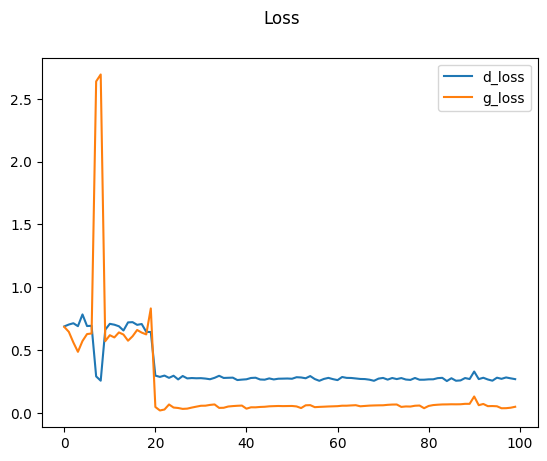

In [29]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

**5. Test Out the Generator**

**5.1 Generate Images**

In [39]:
imgs = generator.predict(tf.random.normal((100, 128, 1)))

4/4 [==============================] - 1s 6ms/step


In [40]:
imgs.shape

(100, 28, 28, 1)

In [46]:
# Select the images generated by last 16 epochs out of 100 epochs to see how good are the results
recent_generated_imgs = imgs[-16:]

In [47]:
recent_generated_imgs.shape

(16, 28, 28, 1)

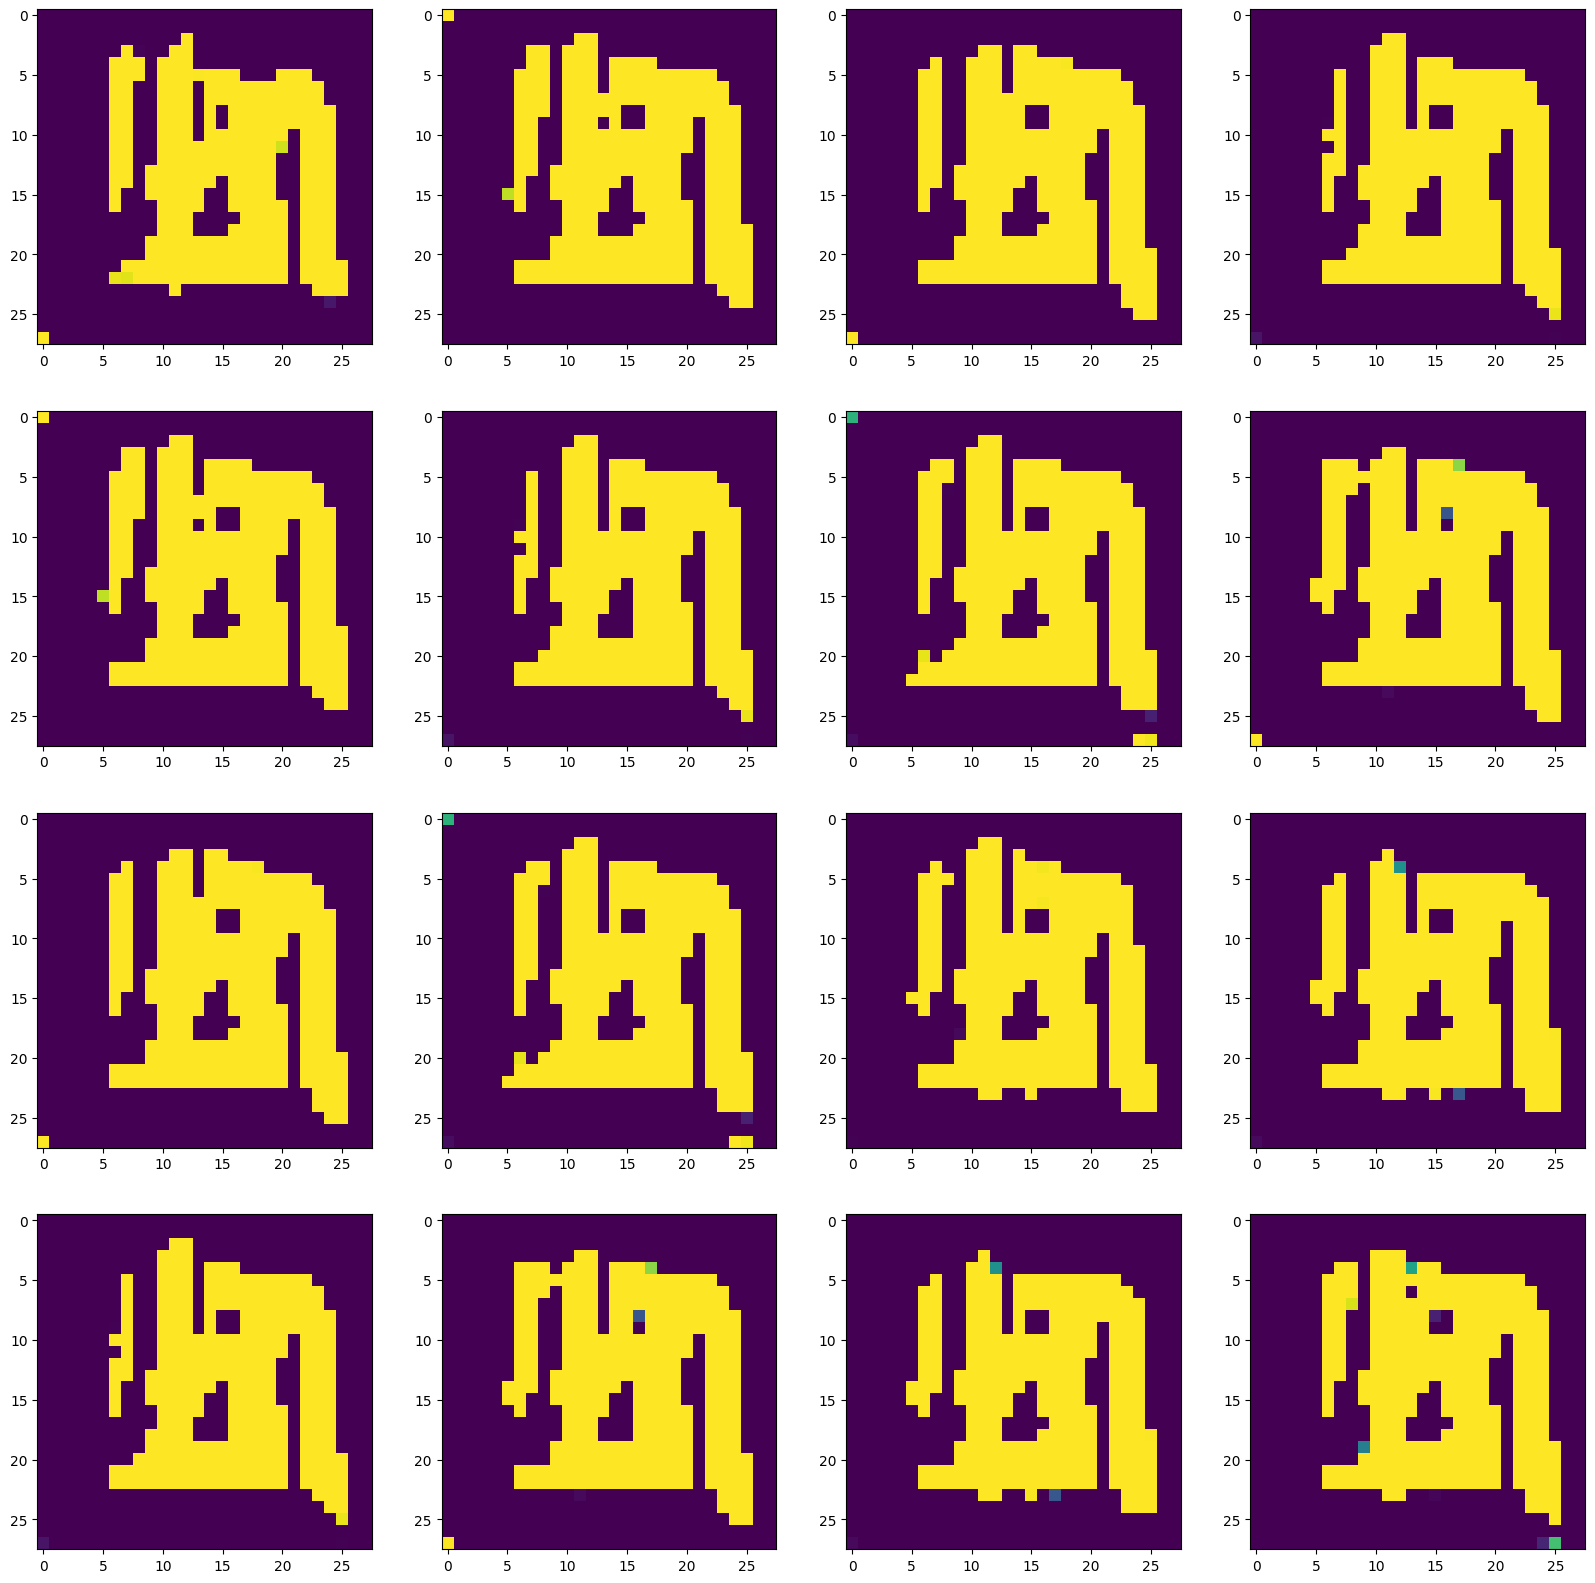

In [49]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(recent_generated_imgs[(r+1)*(c+1)-1])

**5.2 Save the Model**

In [52]:
#generator.save('generator.h5')
#discriminator.save('discriminator.h5')

In [54]:
#generator.save('generator.keras')
#discriminator.save('discriminator.keras')

**6. Next Steps**

In [ ]:
# The results generated by GAN model is not closer to a real Fashion image.
# We can increase the epochs count from 100 to 2000 while fitting the GAN model